In [25]:
import csv
import pandas as pd
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from PIL import Image
from scipy.spatial.distance import cdist
import bisect 
from scipy.spatial import ConvexHull
import gc
import debias_clip as dclip
import copy
import sklearn.feature_selection as fs
from image_database import *
#import cvxpy as cp
image_folder_prefix = 'datasets/gender_in_image_search/google/'

data = pd.read_csv('datasets/gender_in_image_search/gender_labelled_images.csv')

In [26]:
## Preprocessing

catagories = data['search_term'].unique()
data['image_relative_path'] = data['image_url'].str.replace("http://homes.cs.washington.edu/~mjskay/aws-images/google/", image_folder_prefix)

print(len(catagories))
print(data.shape)

45
(3262, 16)


C:\Users\Alexa\AppData\Local\Temp\ipykernel_36760\2415674966.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['image_relative_path'] = data['image_url'].str.replace("http://homes.cs.washington.edu/~mjskay/aws-images/google/", image_folder_prefix)


In [ ]:
data.head(10)


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

batch_size = 200

features = process_images(model, preprocess, data['image_relative_path'], batch_size=batch_size)



100%|██████████| 17/17 [00:19<00:00,  1.16s/it]


In [28]:
device_d = "cuda" if torch.cuda.is_available() else "cpu"
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)

batch_size = 200

features_debias = process_images(model_debias, preprocess_debias, data['image_relative_path'], batch_size=batch_size, device=device_d)

device_d = 'cpu'
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)
    



Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████████████| 4.73k/4.73k [00:00<?, ?iB/s]
100%|██████████| 17/17 [00:25<00:00,  1.52s/it]


Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 4.67MiB/s]


In [ ]:
image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of a young person", "A picture of an old person")])

#print(image_database.search("This is a picture of a engineer."))
print(image_database.distinct_retrival("This is a picture of a pilot.", method='feature_distances', k=10))

#image_database.define_pbm_classes(["unknown gender", "man", "woman"])
#print(image_database.pbm("This is a picture of a customer service representative.", eps=0))

#debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)
#debias_database.search("This is a picture of a engineer.")


#image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])
#print(image_database.true_coordinates)
#print(image_database.data['image_gender'])
#print(image_database.distinct_retrival("This is a picture of a pilot.", method='true_labels'))



#image_database.add_clipclip_ordering("gender", ord)
#image_database.clip_clip("This is a picture of a pilot", "gender", 350, k=10)

In [ ]:
print(ord.shape)



In [29]:
def run_analysis(method_call, k, tol, result_dict, catagories, catagorical_column, label_indistinguishable_values_list, protected_columns, protected_positive_values, protected_negative_values, true_rates, totals_by_cat, prefix="This is a picture of a"):
    result_dict['k'] = k
    result_dict['tol'] = tol
    result_dict['precision'] = np.zeros(len(catagories))
    result_dict['precision_up_to_indistinguishablity'] = np.zeros(len(catagories))
    result_dict['recall'] = np.zeros(len(catagories))
    result_dict['bias'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['abs_bias'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['skew'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['bias_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['abs_bias_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['skews_for_accurate'] = np.zeros((len(catagories), len(protected_columns)))
    result_dict['max_skew'] = np.zeros(len(catagories))
    result_dict['min_skew'] = np.zeros(len(catagories))
    result_dict['worst_multiclass_error'] = np.zeros(len(catagories))



    for i, cat in enumerate(catagories):
        res = method_call(f"{prefix} {cat}")
        result_dict['precision'][i] = precision(label_column=catagorical_column, positive_label_value=cat, data=res)
        result_dict['precision_up_to_indistinguishablity'][i] = precision_up_to_indistinguishablity(label_column=catagorical_column, indistinguishable_labels=label_indistinguishable_values_list[i], data=res)
        result_dict['recall'][i] = recall(label_column=catagorical_column, positive_label_value=cat, data=res, total_positive=totals_by_cat[cat])
        biases = np.zeros(len(protected_columns))
        skews = np.zeros(len(protected_columns))
        abs_biases = np.zeros(len(protected_columns))
        biases_for_accurate = np.zeros(len(protected_columns))
        abs_biases_for_accurate = np.zeros(len(protected_columns))
        skews_for_accurate = np.zeros(len(protected_columns))

        for j, (protected_col, protected_pos_vals, protected_neg_vals) in enumerate(zip(protected_columns, protected_positive_values, protected_negative_values)):
            abs_bias, abs_bias_in_correct_retrievals = abs_bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, protected_negative_values=protected_neg_vals)
            bias, bias_in_correct_retrievals = bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, protected_negative_values=protected_neg_vals)
            biases[j] = bias
            biases_for_accurate[j] = bias_in_correct_retrievals
            abs_biases[j] = abs_bias
            abs_biases_for_accurate[j] = abs_bias_in_correct_retrievals
            skew, skew_for_accurate = skew_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_column=protected_col, protected_positive_values=protected_pos_vals, true_rate=true_rates[j][i])
            skews[j] = skew
            skews_for_accurate[j] = skew_for_accurate
        
        result_dict['bias'][i] = biases
        result_dict['abs_bias'][i] = abs_biases
        result_dict['skew'][i] = skews
        result_dict['bias_for_accurate'][i] = biases_for_accurate
        result_dict['abs_bias_for_accurate'][i] = abs_biases_for_accurate
        result_dict['skews_for_accurate'][i] = skews_for_accurate
        result_dict['max_skew'][i] = max(skews)
        result_dict['min_skew'][i] = min(skews)
        result_dict['worst_multiclass_error'][i] = multiclass_bias_in_retrieval(label_column=catagorical_column, positive_label_values=[cat], data=res, protected_columns=protected_columns, protected_positive_values=protected_positive_values, protected_negative_values=protected_negative_values)

    return result_dict

def parse_analysis(result_dicts, protected_column_names):
    data = []
    for result in result_dicts:
        parsed_result = {}
        if result['tol'] is not None:
            if result['name'][0:3] == "PBM":
                parsed_result['method'] = result['name'] + "(eps " + str(result['tol']) + ")"
            parsed_result['method'] = result['name'] + " (tol: " + str(result['tol']) + ")"
        else:
            parsed_result['method'] = result['name']
        parsed_result['name'] = result['name']
        parsed_result['tol'] = result['tol']
        parsed_result['k'] = result['k']
        parsed_result['Avg_Precision'] = np.mean(result['precision'])
        parsed_result['Avg_Recall'] = np.mean(result['recall'])
        parsed_result['Avg_PutI'] = np.mean(result['precision_up_to_indistinguishablity'])

        for i, protected_col in enumerate(protected_column_names):
            parsed_result[f'Avg_AbsBias_{protected_col}'] = np.mean(result['abs_bias'][:,i])
            parsed_result[f'Avg_Bias_{protected_col}'] = np.mean(result['bias'][:,i])
            parsed_result[f'Avg_Skew_{protected_col}'] = np.mean(result['skew'][:,i])
            parsed_result[f'Avg_Abs_Skew_{protected_col}'] = np.mean(np.abs(result['skew'][:,i]))
            parsed_result[f'Avg_AbsBias_for_Accurate_{protected_col}'] = np.mean(result['abs_bias_for_accurate'][:,i])

        parsed_result['Avg_Max_MC_Bias'] =np.mean(result['worst_multiclass_error'])

        if len(protected_column_names) > 1:
            parsed_result['Max_AbsBias'] = np.max([np.mean(result['abs_bias'][:,i]) for i in range(len(protected_column_names))])

        data.append(parsed_result.copy())

    df = pd.DataFrame(data)
    return df

image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")]) #
image_database.define_pbm_classes(["unknown gender", "man", "woman"])
debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)

baseline_metrics = {'name': 'Baseline'}
random_from_similar_set_metrics = {'name': 'RandomSS'}
divimage_max_sum_metrics = {'name': 'DivImageMSum'}
divimage_max_min_metrics = {'name': 'DivImageMMin'}
#diviamge_clustering_metrics = {'name': 'DivImageC'}
#divimage_qp_metrics = {'name': 'DivImageQP'}
random_from_similar_set_metrics_larger_tol = {'name': 'RandomSS'}
divimage_max_sum_metrics_larger_tol = {'name': 'DivImageMSum'}
divimage_max_min_metrics_larger_tol = {'name': 'DivImageMMin'}
pbm_metrics = {'name': 'PBM'}
pbm_intersectional_metrics = {'name': 'PBM_Intersectional'}
debias_clip_metrics = {'name': 'DebiasClip'}
true_labels = {'name': 'TrueConceptLabels'}
true_labels_larger_tol = {'name': 'TrueConceptLabels'}


indistinguisable_values = [[cat] for cat in catagories]
true_rates = [[data[data['search_term'] == cat].iloc[0].search_p_women for cat in catagories]]
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])

run_analysis(lambda x: image_database.search(x, 50), 50, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
run_analysis(lambda x: image_database.distinct_retrival(x, 50, tol=.03, method='max_sum'), 50, .03, divimage_max_sum_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='max_min'), 25, .02, divimage_max_min_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='random'), 25, .02, random_from_similar_set_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='max_sum'), 25, .04, divimage_max_sum_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='max_min'), 25, .04, divimage_max_min_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='random'), 25, .04, random_from_similar_set_metrics_larger_tol, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: image_database.pbm(x, 25, eps=0), 25, None, pbm_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#image_database.define_pbm_classes(["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])
#run_analysis(lambda x: image_database.pbm(x, 25, eps=0), 25, None, pbm_intersectional_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: debias_database.search(x, 25), 25, None, debias_clip_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.02, method='true_labels'), 25, .02, true_labels, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
#run_analysis(lambda x: image_database.distinct_retrival(x, 25, tol=.04, method='true_labels'), 25, .04, true_labels_larger_tol, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)


#df = parse_analysis([baseline_metrics, divimage_max_sum_metrics, divimage_max_min_metrics, random_from_similar_set_metrics, divimage_max_sum_metrics_larger_tol, divimage_max_min_metrics_larger_tol, random_from_similar_set_metrics_larger_tol, pbm_metrics, pbm_intersectional_metrics, debias_clip_metrics, true_labels, true_labels_larger_tol], ['gender'])
"""plt.hist(baseline_metrics['precision'] - divimage_metrics['precision'])
plt.show()

plt.hist(baseline_metrics['bias'] - divimage_metrics['bias'])
plt.show()"""

#print(f"Baseline Average Bias: {np.mean(baseline_metrics['bias'])}, DivImage Average Bias: {np.mean(divimage_metrics['bias'])}")

#print(divimage_metrics['bias'])
#print(df)

"plt.hist(baseline_metrics['precision'] - divimage_metrics['precision'])\nplt.show()\n\nplt.hist(baseline_metrics['bias'] - divimage_metrics['bias'])\nplt.show()"

dict_keys(['name', 'k', 'tol', 'precision', 'precision_up_to_indistinguishablity', 'recall', 'bias', 'abs_bias', 'skew', 'bias_for_accurate', 'abs_bias_for_accurate', 'skews_for_accurate', 'max_skew', 'min_skew', 'worst_multiclass_error'])


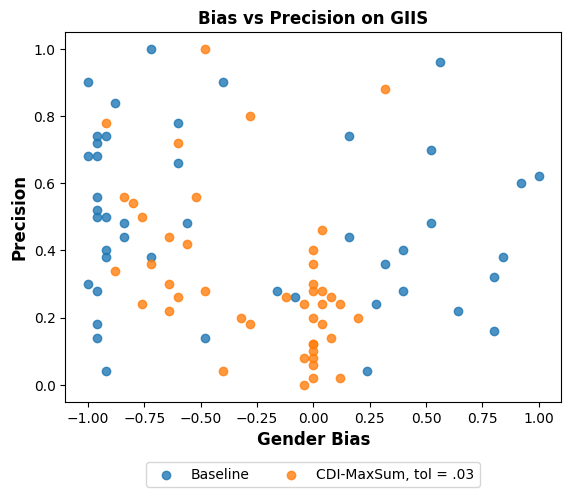

In [30]:
print(baseline_metrics.keys())
#print(baseline_metrics['bias'])
divimage_max_sum_metrics

plt.scatter(baseline_metrics['bias'], baseline_metrics['precision'], alpha=.8)
plt.scatter(divimage_max_sum_metrics['bias'], divimage_max_sum_metrics['precision'], alpha=.8)
plt.title("Bias vs Precision on GIIS", weight='bold')
plt.xlabel("Gender Bias", weight='bold', fontsize=12)
plt.ylabel("Precision", weight='bold', fontsize=12)
plt.legend(["Baseline", "CDI-MaxSum, tol = .03"], loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.show()


In [ ]:
### For precision-bias and recall-bias graphs --

number_of_tol_steps = 15
methods = [
    'max_sum', 'max_min', 'random', 'true_labels', 'PBM_gender', 'PBM_skintone', 'PBM_intersectional'
]

#methods = ['PBM', 'PBM_Intersectional']

image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a white person", "A picture of a black person")])

debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)

totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])

random_iters = 5

for k in [10, 25, 50, 100]:
    print(f"Starting analysis for k: {k}...")
    precisions, biases, skews, abs_biases, abs_bias_for_accurate = {}, {}, {}, {}, {}

    #max_skew = []
    #min_skew = []

    for method in methods:
        print(f"Method: {method}...")
        avg_precision = []
        avg_bias = []
        avg_skew = []
        avg_abs_bias = []
        avg_abs_bias_for_accurate = []
        if method[0:3] == 'PBM':
            if method == 'PBM_gender':
                image_database.define_pbm_classes(["unknown gender", "man", "woman"])
            elif method == 'PBM_skintone':
                image_database.define_pbm_classes(["unknown skin-tone", "light-skinned person", "dark-skinned person"])
            elif method == 'PBM_intersectional':
                image_database.define_pbm_classes(["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])
            for eps in tqdm(reversed(range(0, 11))):
                mean_precision = 0
                mean_bias = 0
                mean_skew = 0
                mean_abs_bias = 0
                mean_abs_average_bias_for_accurate = 0
                for i in range(random_iters):
                    baseline_metrics = {}
                    run_analysis(lambda x: image_database.pbm(x, k, eps=eps/10), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
                    mean_precision += np.mean(baseline_metrics['precision'])
                    mean_bias += np.mean(baseline_metrics['bias'])
                    mean_abs_bias += np.mean(baseline_metrics['abs_bias'])
                    mean_skew += np.mean(baseline_metrics['skew'])
                    mean_abs_average_bias_for_accurate += np.mean(baseline_metrics['abs_bias_for_accurate'])

                avg_precision.append(mean_precision / random_iters)
                avg_bias.append(mean_bias / random_iters)
                avg_skew.append(mean_skew / random_iters)
                avg_abs_bias.append(mean_abs_bias / random_iters)
                avg_abs_bias_for_accurate.append(mean_abs_average_bias_for_accurate / random_iters)
                gc.collect()
                torch.cuda.empty_cache()

        else:
            for tol in tqdm(range(0, number_of_tol_steps)):
                baseline_metrics = {}
                gc.collect()
                torch.cuda.empty_cache()
                t = tol / (10 * (number_of_tol_steps-1))
                ## This is inefficient write a faster way to vary tol and rerun the analysis
                if method == 'random':
                    mean_precision = 0
                    mean_bias = 0
                    mean_skew = 0
                    mean_abs_bias = 0
                    mean_abs_average_bias_for_accurate = 0
                    for i in range(random_iters):
                        baseline_metrics = {}
                        run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method=method), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
                        mean_precision += np.mean(baseline_metrics['precision'])
                        mean_bias += np.mean(baseline_metrics['bias'])
                        mean_skew += np.mean(baseline_metrics['skew'])
                        mean_abs_bias += np.mean(baseline_metrics['abs_bias'])
                        mean_abs_average_bias_for_accurate += np.mean(baseline_metrics['abs_bias_for_accurate'])
                    avg_precision.append(mean_precision/random_iters)
                    avg_bias.append(mean_bias/random_iters)
                    avg_skew.append(mean_skew/random_iters)
                    avg_abs_bias.append(mean_abs_bias/random_iters)
                    avg_abs_bias_for_accurate.append(mean_abs_average_bias_for_accurate/random_iters)

                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method=method), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
                    avg_precision.append(np.mean(baseline_metrics['precision']))
                    avg_bias.append(np.mean(baseline_metrics['bias']))
                    avg_skew.append(np.mean(baseline_metrics['skew']))
                    avg_abs_bias.append(np.mean(baseline_metrics['abs_bias']))
                    avg_abs_bias_for_accurate.append(np.mean(baseline_metrics['abs_bias_for_accurate']))
                
                #max_skew.append(np.mean(divimage_metrics['max_skew']))
                #min_skew.append(np.mean(divimage_metrics['min_skew']))
        precisions[method] = avg_precision
        biases[method] = avg_bias
        skews[method] = avg_skew
        abs_biases[method] = avg_abs_bias
        abs_bias_for_accurate[method] = avg_abs_bias_for_accurate

    print("Computing Baseline...")
    baseline_metrics = {}
    run_analysis(lambda x: image_database.search(x, k), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
    baseline_precision = np.mean(baseline_metrics['precision'])
    baseline_bias = np.mean(baseline_metrics['bias'])
    baseline_skew = np.mean(baseline_metrics['skew'])
    baseline_abs_bias = np.mean(baseline_metrics['abs_bias']) 
    baseline_abs_bias_for_accurate = np.mean(baseline_metrics['abs_bias_for_accurate'])


    print("Computing Debias-Prompt...")
    debias_metrics = {}
    run_analysis(lambda x: debias_database.search(x, k), k, None, debias_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates)
    debias_precision = np.mean(debias_metrics['precision'])
    debias_bias = np.mean(debias_metrics['bias'])
    debias_skew = np.mean(debias_metrics['skew'])
    debias_abs_bias = np.mean(debias_metrics['abs_bias'])
    debias_abs_bias_for_accurate = np.mean(debias_metrics['abs_bias_for_accurate'])

    for method in methods:
        plt.plot(biases[method], precisions[method], label=method)
    plt.scatter(baseline_bias, baseline_precision, label='Baseline', color = 'black')
    plt.scatter(debias_bias, debias_precision, label='Debias', color = 'red')
    plt.grid()
    plt.xlabel("Average Bias")
    plt.ylabel("Average Precision")
    #plt.gca().invert_xaxis()
    plt.title(f"Precision-Bias Curve @ {k}")
    plt.legend()
    plt.show()

    for method in methods:
        plt.plot(abs_biases[method], precisions[method], label=method)
    plt.scatter(baseline_abs_bias, baseline_precision, label='Baseline', color = 'black')
    plt.scatter(debias_abs_bias, debias_precision, label='Debias', color = 'red')
    plt.grid()
    plt.xlabel("Average AbsBias")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

    for method in methods:
        plt.plot(abs_bias_for_accurate[method], precisions[method], label=method)
    plt.scatter(baseline_abs_bias_for_accurate, baseline_precision, label='Baseline', color = 'black')
    plt.scatter(debias_abs_bias_for_accurate, debias_precision, label='Debias', color = 'red')
    plt.grid()
    plt.xlabel("Average AbsBias for Accurate")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve for Accurate Labels @ {k}")
    plt.legend()
    plt.show()


    for method in methods:
        plt.plot(skews[method], precisions[method], label=method)
    plt.scatter(baseline_skew, baseline_precision, label='Baseline', color='black')
    plt.scatter(debias_skew, debias_precision, label='Debias', color='red')
    plt.grid()
    plt.xlabel("Average Skew")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-Skew Curve @ {k}")
    plt.legend()
    plt.show()

    for method in methods:
        plt.scatter(biases[method], skews[method], label=method)
    plt.scatter(baseline_bias, baseline_skew, label='Baseline', color='black')
    plt.scatter(debias_bias, debias_skew, label='Debias', color='red')
    plt.legend()
    plt.grid()
    plt.ylabel("Average Skew")
    plt.xlabel("Average Bias")
    plt.title(f"Bias-Skew Scatter @ {k}")
    plt.show()




In [6]:
attr = [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of a young person", "A picture of an old person"), ("A picture of an American Person", "A picture of a non-American person"), ("A picture of a disabled person", "A picture of a person who is not disabled")]
image_database = ImageDatabase(features, data, model, preprocess, device)
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])


ks = [10, 25, 50]
number_of_tol_steps = 20

for k in ks:
    precisions, biases, recalls = {}, {}, {}
    for i in tqdm(range(len(attr))):
        avg_precision = []
        avg_bias = []
        avg_recall = []
        image_database.sensitive_attributes(attr[:i+1])
        for tol in range(0, number_of_tol_steps):
            baseline_metrics = {}
            t = tol / (200)
            run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method='max_sum'), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
            avg_precision.append(np.mean(baseline_metrics['precision']))
            avg_bias.append(np.mean(baseline_metrics['abs_bias']))
            avg_recall.append(np.mean(baseline_metrics['recall']))
        precisions[str(i)] = avg_precision
        biases[str(i)] = avg_bias
        recalls[str(i)] = avg_recall


    baseline_metrics = {}
    run_analysis(lambda x: image_database.search(x, k), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
    baseline_precision = np.mean(baseline_metrics['precision'])
    baseline_bias = np.mean(baseline_metrics['abs_bias'])
    baseline_recall = np.mean(baseline_metrics['recall'])

    for i in range(len(attr)):
        plt.plot(biases[str(i)], precisions[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(baseline_bias, baseline_precision, label='Baseline')
    plt.grid()
    plt.xlabel("Average AbsBias")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

    for i in range(len(attr)):
        plt.plot(biases[str(i)], recalls[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(baseline_bias, baseline_recall, label='Baseline')
    plt.grid()
    plt.xlabel("Average AbsBias")
    plt.ylabel("Average Recall")
    plt.gca().invert_xaxis()
    plt.title(f"Recall-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

    for i in range(len(attr)):
        plt.plot(recalls[str(i)], precisions[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(baseline_bias, baseline_recall, label='Baseline')
    plt.grid()
    plt.xlabel("Average Recall")
    plt.ylabel("Average Precision")
    plt.title(f"Precision-Recall Curve @ {k}")
    plt.legend()
    plt.show()

            

  0%|          | 0/5 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [8]:

image_database = ImageDatabase(features, data, model, preprocess, device)
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
image_database.define_coordinate_mapping(['image_gender'], [['man']], [['woman']])
indistinguisable_values = [[cat] for cat in catagories]
true_rates = [[data[data['search_term'] == cat].iloc[0].search_p_women for cat in catagories]]
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}

image_database.add_clipclip_ordering("gender", np.load('datasets/MI_orders/gender.npy'))
image_database.add_clipclip_ordering("skintone", np.load('datasets/MI_orders/skintone.npy'))
image_database.add_clipclip_ordering("intersectional", np.load('datasets/MI_orders/gender_skintone.npy'))
image_database.add_clipclip_ordering("three_attr", np.load('datasets/MI_orders/intersectional.npy'))


"""method_name_specification_list = [
    (lambda k, tol: lambda x: image_database.search(x, k), 'Baseline', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_gender', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_gender', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='random'), 'CDI_Random', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='true_labels'), 'CDI_TrueConcept', []),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_gender', [("pbm_classes", ["unknown gender", "man", "woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_intersectional', [("pbm_classes", ["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_skintone', [("pbm_classes", ["unknown skin-tone", "light-skinned person", "dark-skinned person"])]),
    (lambda k, tol: lambda x: debias_database.search(x, k), 'DebiasClip', [])
]"""

"""method_name_specification_list = [
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_gender', [("pbm_classes", ["unknown gender", "man", "woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_intersectional', [("pbm_classes", ["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_skintone', [("pbm_classes", ["unknown skin-tone", "light-skinned person", "dark-skinned person"])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='feature_distances'), 'CDI_Features', [])
]"""

method_name_specification_list = [
    (lambda k, n: lambda x: image_database.clip_clip(x, "gender", n, k), 'CLIP_gender', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "skintone", n, k), 'CLIP_skintone', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "intersectional", n, k), 'CLIP_intersectional', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "three_attr", n, k), 'CLIP_three_attributes', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])])
]

ks = [10, 25, 50, 100]

number_of_tol_steps = 16
number_of_eps_steps = 11
random_iters = 4
number_of_clip_clip_steps = 24

result_dicts = []

for method, name, spec in method_name_specification_list:
    print(f"Starting analysis for method: {name}...")
    for s, val in spec:
        if s == "sensitive_attributes":
            image_database.sensitive_attributes(val)
        if s == "pbm_classes":
            image_database.define_pbm_classes(val)
    for k in tqdm(ks):
        result_dict = {'name': name}

        if name in ['Baseline', "DebiasClip"]:
            steps = 1
        else:
            steps = number_of_tol_steps

        if name[0:3] == 'PBM':
            for e in reversed(range(0, number_of_eps_steps)):
                eps = e / (number_of_eps_steps - 1)
                retrieval_function = method(k, eps)
                new_dict = result_dict.copy()
                random_results = []
                for i in range(random_iters):
                    new_dict = result_dict.copy()
                    run_analysis(retrieval_function, k, eps, new_dict, catagories, 'search_term', indistinguisable_values,  ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
                    random_results.append(new_dict)
                
                add_dict = result_dict.copy()
                for key in random_results[0].keys():
                    if key == 'name':
                        continue
                    add_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                result_dicts.append(add_dict)
        
        elif name[0:4] == 'CLIP':
            for e in range(0, number_of_clip_clip_steps):
                n = e * 20
                retrieval_function = method(k, n)
                new_dict = result_dict.copy()
                run_analysis(retrieval_function, k, n, new_dict, catagories, 'search_term', indistinguisable_values, ['image_gender'],  [['woman']], [['man']], true_rates, totals_by_cat)
                result_dicts.append(new_dict)

        else:
            for t in range(0, steps):
                if steps == 1:
                    tol = None
                else:
                    tol = t / 200
                retrieval_function = method(k, tol)
                new_dict = result_dict.copy()
                if name == "CDI_Random":
                    random_results = []
                    for i in range(random_iters):
                        new_dict = result_dict.copy()
                        run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values,  ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
                        random_results.append(new_dict)
                    new_dict = result_dict.copy()

                    for key in random_results[0].keys():
                        if key == 'name':
                            continue
                        new_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                else:
                    run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values, ['image_gender'], [['woman']], [['man']], true_rates, totals_by_cat)
                result_dicts.append(new_dict)

df = parse_analysis(result_dicts, ['gender'])

print(df)

df.to_pickle("results/giis-3-24-CLIP-euc.pkl")
        

Starting analysis for method: CLIP_gender...


100%|██████████| 4/4 [00:59<00:00, 14.89s/it]


Starting analysis for method: CLIP_skintone...


100%|██████████| 4/4 [03:21<00:00, 50.28s/it]


Starting analysis for method: CLIP_intersectional...


100%|██████████| 4/4 [03:11<00:00, 47.90s/it]


Starting analysis for method: CLIP_three_attributes...


100%|██████████| 4/4 [03:19<00:00, 49.95s/it]


Starting analysis for method: CDI_Min_skintone...


100%|██████████| 4/4 [08:01<00:00, 120.27s/it]


Starting analysis for method: CDI_EucSum_intersectional...


100%|██████████| 4/4 [06:15<00:00, 93.77s/it] 


Starting analysis for method: CDI_EucMin_intersectional...


100%|██████████| 4/4 [15:01<00:00, 225.30s/it]


                                     method                       name  \
0                      CLIP_gender (tol: 0)                CLIP_gender   
1                     CLIP_gender (tol: 20)                CLIP_gender   
2                     CLIP_gender (tol: 40)                CLIP_gender   
3                     CLIP_gender (tol: 60)                CLIP_gender   
4                     CLIP_gender (tol: 80)                CLIP_gender   
..                                      ...                        ...   
571  CDI_EucMin_intersectional (tol: 0.055)  CDI_EucMin_intersectional   
572   CDI_EucMin_intersectional (tol: 0.06)  CDI_EucMin_intersectional   
573  CDI_EucMin_intersectional (tol: 0.065)  CDI_EucMin_intersectional   
574   CDI_EucMin_intersectional (tol: 0.07)  CDI_EucMin_intersectional   
575  CDI_EucMin_intersectional (tol: 0.075)  CDI_EucMin_intersectional   

        tol    k  Avg_Precision  Avg_Recall  Avg_PutI  Avg_AbsBias_gender  \
0     0.000   10       0.655556   

In [ ]:
df2 = pd.read_pickle("results/giis-3-21.pkl")

print(df2)

In [ ]:
method_names = ['Baseline', 'DebiasClip', "CDI_Sum_gender"]
method_names = df2['name'].unique()

for k in [10, 25, 50, 100]:
    plot_across_tol(df2, 25, method_names, 'Avg_AbsBias_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df2, 25, method_names, 'Avg_Bias_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df2, 25, method_names, 'Avg_Skew_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df2, 25, method_names, 'Avg_AbsBias_gender', 'Avg_Recall', reverse_x=True)
    plot_across_tol(df2, 25, method_names, 'Avg_Bias_gender', 'Avg_Recall', reverse_x=False)
    plot_across_tol(df2, 25, method_names, 'Avg_AbsBias_for_Accurate_gender', 'Avg_Precision', reverse_x=True)